In [98]:
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

random.seed(42)

csv_files = ['BAYZF.csv', 'HON.csv', 'MMM.csv', 'SYF.csv']
fpath = './Data Given/' + csv_files[0]
df = pd.read_csv(fpath)
df = df.dropna()
df = df[['Date', 'Open', 'High', 'Low', 'Close']]
print(df.head(10))


        Date       Open       High        Low      Close
0  2/13/2009  55.549999  55.549999  55.549999  55.549999
1  2/17/2009  53.400002  53.400002  53.099998  53.200001
2  2/18/2009  53.400002  53.400002  53.299999  53.299999
3  2/19/2009  54.250000  54.250000  53.750000  53.750000
4  2/20/2009  52.299999  52.299999  51.900002  51.910000
5  2/23/2009  53.540001  53.540001  51.750000  52.000000
6  2/24/2009  52.500000  52.500000  51.250000  51.250000
7  2/25/2009  50.660000  50.660000  50.660000  50.660000
8  2/26/2009  48.500000  48.500000  48.500000  48.500000
9  2/27/2009  47.700001  48.650002  47.700001  48.500000


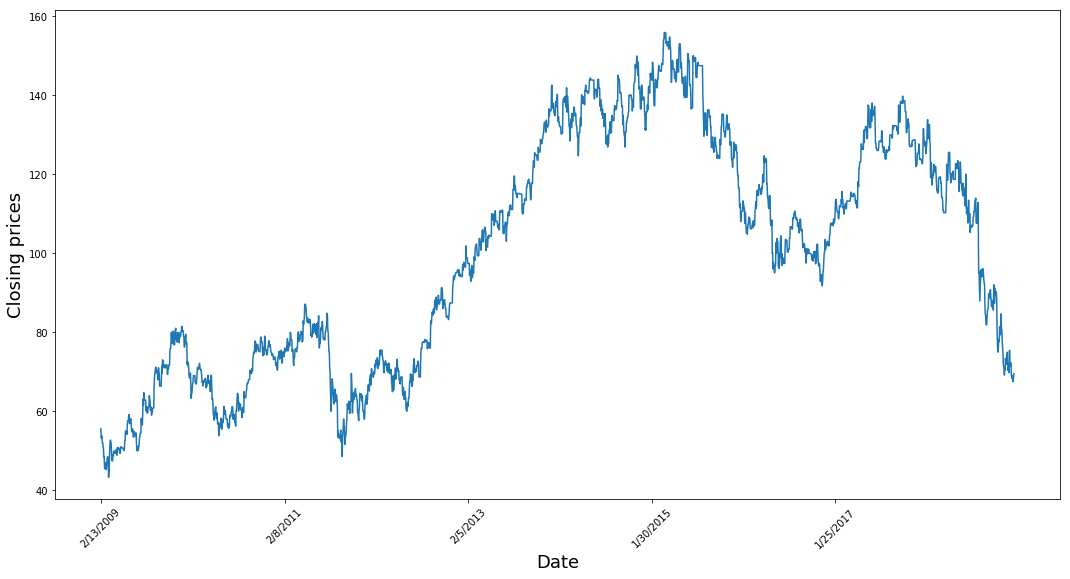

In [99]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), df['Close'])
plt.xticks(range(0,df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing prices', fontsize=18)
plt.show()

In [100]:
df['Month'] = df['Date'].map(lambda x: x.split('/')[0])
df['Day'] = df['Date'].map(lambda x: x.split('/')[1])

In [108]:
input_features = df[['Close', 'Month', 'Day']].loc[:].values


split_idx = int(0.8*len(input_features))
train_data = input_features[:split_idx]
test_data = input_features[split_idx:]

sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_data)
test_set_scaled = sc.transform(test_data)


[[55.549999 '2' '13']
 [53.200001 '2' '17']
 [53.299999 '2' '18']
 ...
 [106.779999 '1' '4']
 [107.610001 '1' '5']
 [107.610001 '1' '6']]


/home/foobar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [110]:
X_train = []
Y_train = []

chunk_size = 60
for i in range(chunk_size, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i])
    Y_train.append(training_set_scaled[i, 0])
    # print(training_set_scaled[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))


array([0.06530433, 0.0630831 , 0.0630831 , ..., 0.56401596, 0.57139048,
       0.57139048])

In [103]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, Y_train, epochs=4, batch_size=32)
          

Epoch 1/4
1929/1929 [==============================] - 64s 33ms/step - loss: 0.0309
Epoch 2/4
1929/1929 [==============================] - 61s 31ms/step - loss: 0.0049
Epoch 3/4
1929/1929 [==============================] - 61s 32ms/step - loss: 0.0051
Epoch 4/4
1929/1929 [==============================] - 59s 31ms/step - loss: 0.0048


In [111]:
num_days = 50
total_data = np.concatenate((training_set_scaled, test_set_scaled))
predicted_stock_prices = []

for day in range(num_days):
    curr_idx = len(training_set_scaled) + day
    
    start_idx = len(total_data) - len(test_set_scaled) - chunk_size + day
    end_idx = start_idx+chunk_size
    inputs = total_data[start_idx:end_idx]
    X_test = []
    X_test.append(inputs)
        
    X_test = np.array(X_test)
    # X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = model.predict(X_test)
    total_data[curr_idx][0] = predicted_stock_price
    predicted_stock_price = sc.inverse_transform(total_data[curr_idx].reshape(1, -1))[0][0]
    predicted_stock_prices.append(predicted_stock_price)

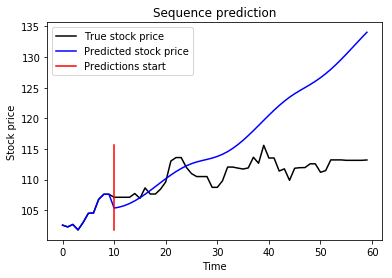

[105.35551844088614, 105.51298713618762, 105.76127554763067, 106.1026578577956, 106.53212281480194, 107.0397686679461, 107.61020611091782, 108.2253020596034, 108.86590373740482, 109.51336821396626, 110.14859638071513, 110.75397170828319, 111.31419880940473, 111.81673278312064, 112.25195363586116, 112.6104828801713, 112.88472649044371, 113.10202832566739, 113.29976145709544, 113.51710354333824, 113.78719459013809, 114.13407787291611, 114.57132469361902, 115.10290648613334, 115.72485181657255, 116.42591723359574, 117.19042496525556, 118.00042976552761, 118.83746312513888, 119.68390180621792, 120.52090833181644, 121.33086617256618, 122.09835247964091, 122.81065463950182, 123.45565709539372, 124.02351176463854, 124.53655796284801, 125.02549380060447, 125.52229871259892, 126.05357862246984, 126.63839238777065, 127.28723210748537, 128.00273422336633, 128.781141973629, 129.61254019056344, 130.48347161677714, 131.37884882860314, 132.28336973027265, 133.1825238293928, 134.06137128936678]


In [121]:
actual_line = np.concatenate((train_data[-10:, 0], test_data[:num_days, 0]))
predicted_line = np.concatenate((train_data[-10:, 0], predicted_stock_prices))

plt.plot(actual_line, color='black', label='True stock price')
plt.plot(predicted_line, color='blue', label='Predicted stock price')
plt.plot((10, 10), (np.min(actual_line), np.max(actual_line)), 'k-', color='red', label='Predictions start')
plt.title("Sequence prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()
print(predicted_stock_prices)